Loads 3 datasets (climate, yield, flavor),

Cleans and standardizes column names,

Merges them on Country and Year,

Encodes text columns to numbers,

Fills missing values (per country, then with median),

Saves the final cleaned dataset as final_merged_dataset.csv.

In [47]:
import pandas as pd
import numpy as np

# Step 1: Load all 3 datasets
climate_df = pd.read_csv("Climate_dataset.csv")
yield_df = pd.read_csv("UNdata_Cleaned_Yield-2.csv")
flavor_df = pd.read_csv("full_flavors_of_cocoa_cleaned-2.csv")

# Step 2: Standardize column names
climate_df.columns = climate_df.columns.str.strip()
yield_df.columns = yield_df.columns.str.strip()
flavor_df.columns = flavor_df.columns.str.strip()

# Step 3: Rename columns for consistency
flavor_df = flavor_df.rename(columns={"Bean Origin": "Country", "Review Date": "Year"})
climate_df = climate_df.rename(columns={"Country ": "Country"})

# Step 4: Convert Year to numeric
flavor_df["Year"] = pd.to_numeric(flavor_df["Year"], errors="coerce")
climate_df["Year"] = pd.to_numeric(climate_df["Year"], errors="coerce")
yield_df["Year"] = pd.to_numeric(yield_df["Year"], errors="coerce")

# Step 5: Merge datasets (base = flavor dataset)
merged = pd.merge(flavor_df, climate_df, on=["Country", "Year"], how="left")
merged = pd.merge(merged, yield_df, on=["Country", "Year"], how="left")

# Step 6: Drop irrelevant columns if they exist
drop_cols = [
    "Domain Code", "Country  Code", "Element Code", "Months Code", "Months",
    "Flag", "Flag Description", "Unnamed: 10", "Id", "Company"
]
merged = merged.drop(columns=[col for col in drop_cols if col in merged.columns])

# Step 7: Encode all object columns (string to numeric)
for col in merged.select_dtypes(include="object").columns:
    merged[col] = merged[col].astype("category").cat.codes.replace({-1: np.nan})

# Step 8: Smart fill missing values
# First: fill within each Country using forward + backward fill
merged = merged.sort_values(by=["Country", "Year"])
merged = merged.groupby("Country").ffill().bfill()

# Then: fill any remaining NaNs using column median
for col in merged.columns:
    if merged[col].isnull().sum() > 0:
        merged[col] = merged[col].fillna(merged[col].median())

# Step 9: Save final merged dataset
merged.to_csv("final_merged_dataset.csv", index=False)
print(" Merged dataset saved as 'final_merged_dataset.csv'")
print("Final shape:", merged.shape)


 Merged dataset saved as 'final_merged_dataset.csv'
Final shape: (1792, 8)


In [18]:
import pandas as pd

# Load the dataset
df = pd.read_csv("final_merged_dataset.csv")

# Show all column names
print("📋 Column Names in Dataset:")
print(df.columns.tolist())

# Show first few rows to preview data
print("\n🔍 Sample Rows:")
print(df.head())


📋 Column Names in Dataset:
['Year', 'Cocoa Percent', 'Company Location', 'Rating (Out of 10)', 'Temperature change on land Value in °c', 'Annual precipitation', 'Yield (kg/ha)', 'Yield (t/ha)']

🔍 Sample Rows:
     Year  Cocoa Percent  Company Location  Rating (Out of 10)  \
0  2016.0             37                56              6.0625   
1  2016.0             24                56              7.1875   
2  2010.0              0                29              2.1250   
3  2010.0             20                56              7.1875   
4  2015.0             20                56              6.6250   

   Temperature change on land Value in °c  Annual precipitation  \
0                                   1.067             1639.0797   
1                                   1.067             1639.0797   
2                                   1.067             1639.0797   
3                                   1.067             1639.0797   
4                                   1.067             1639

Loads and preprocesses the dataset

Uses Company Location as condition and Yield (kg/ha) as target

Builds and trains a conditional GAN for 3000 epochs

Generator creates synthetic data based on random noise and conditions

Scales data back and assigns yield values

Saves synthetic dataset as synthetic_data_condgan.csv

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load dataset
df = pd.read_csv("final_merged_dataset.csv")

# Step 2: Set condition and target
condition_col = "Company Location"
target_col = "Yield (kg/ha)"

# Separate features and target
condition = df[condition_col]
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode condition (already numeric) and reshape
n_classes = int(condition.nunique())
condition_input = condition.values.reshape(-1, 1).astype(np.float32)

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert inputs to Tensor
X_tensor = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
cond_tensor = tf.convert_to_tensor(condition_input, dtype=tf.float32)

# Create batched dataset
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((X_tensor, cond_tensor))
dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# GAN Settings
latent_dim = 32
input_dim = X_scaled.shape[1]
epochs = 3000

# Step 3: Build Generator
def build_generator():
    noise_input = layers.Input(shape=(latent_dim,))
    cond_input = layers.Input(shape=(1,))
    x = layers.Concatenate()([noise_input, cond_input])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    output = layers.Dense(input_dim, activation='sigmoid')(x)
    return tf.keras.Model([noise_input, cond_input], output)

# Step 4: Build Discriminator
def build_discriminator():
    data_input = layers.Input(shape=(input_dim,))
    cond_input = layers.Input(shape=(1,))
    x = layers.Concatenate()([data_input, cond_input])
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model([data_input, cond_input], output)

# Instantiate models
generator = build_generator()
discriminator = build_discriminator()

# Loss and optimizers
loss_fn = tf.keras.losses.BinaryCrossentropy()
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

# Step 5: Training Step
@tf.function
def train_step(real_data, real_cond):
    batch_size = tf.shape(real_data)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_data = generator([noise, real_cond], training=True)

        real_output = discriminator([real_data, real_cond], training=True)
        fake_output = discriminator([fake_data, real_cond], training=True)

        d_loss_real = loss_fn(tf.ones_like(real_output), real_output)
        d_loss_fake = loss_fn(tf.zeros_like(fake_output), fake_output)
        d_loss = d_loss_real + d_loss_fake

        g_loss = loss_fn(tf.ones_like(fake_output), fake_output)

    grads_g = g_tape.gradient(g_loss, generator.trainable_variables)
    grads_d = d_tape.gradient(d_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(grads_g, generator.trainable_variables))
    disc_opt.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    return g_loss, d_loss

# Step 6: Train GAN
for epoch in range(epochs):
    for real_data, real_cond in dataset:
        g_loss, d_loss = train_step(real_data, real_cond)

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Generator Loss: {g_loss:.4f} | Discriminator Loss: {d_loss:.4f}")

# Step 7: Generate Synthetic Data
num_samples = 3000
random_noise = tf.random.normal([num_samples, latent_dim])
random_cond = tf.convert_to_tensor(
    np.random.randint(0, n_classes, size=(num_samples, 1)), dtype=tf.float32
)

# Generate new data
synthetic_scaled = generator([random_noise, random_cond], training=False).numpy()
synthetic_data = scaler.inverse_transform(synthetic_scaled)

# Step 8: Create DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=X.columns)
synthetic_df[condition_col] = random_cond.numpy().astype(int)
synthetic_df[target_col] = y.sample(n=num_samples, replace=True).reset_index(drop=True)

# Save to CSV
synthetic_df.to_csv("synthetic_data_condgan.csv", index=False)
print("✅ Synthetic dataset saved as 'synthetic_data_condgan.csv'")


Epoch 0 | Generator Loss: 0.7794 | Discriminator Loss: 1.3678
Epoch 500 | Generator Loss: 0.9845 | Discriminator Loss: 1.3295
Epoch 1000 | Generator Loss: 0.7324 | Discriminator Loss: 1.3806
Epoch 1500 | Generator Loss: 0.7642 | Discriminator Loss: 1.3523
Epoch 2000 | Generator Loss: 0.7745 | Discriminator Loss: 1.2949
Epoch 2500 | Generator Loss: 0.6636 | Discriminator Loss: 1.5732
✅ Synthetic dataset saved as 'synthetic_data_condgan.csv'


**Training a TabNet Regressor on Real + GAN-Synthetic Cocoa Data to Predict Yield**

Installs and imports necessary libraries including TabNet.

Loads the real and synthetic datasets, then combines them.

Defines features and target (Yield (kg/ha)), splits the real data for evaluation.

Trains TabNet on the combined dataset, using real data for testing.

Evaluates the model using R² score and MAE on the real test set.

Model Name: TabNet Regressor (with CondGAN Synthetic Data)

Input Parameters for UI
Country – dropdown (e.g., Ivory Coast → encoded as 3)

Bean Type – dropdown (e.g., Forastero → encoded as 1)

Fertilizer Used – dropdown (e.g., Yes → 1, No → 0)

Cocoa Percent – numeric (e.g., 70)

Temperature Change (°C) – numeric (e.g., 1.25)

Annual Precipitation (mm) – numeric (e.g., 1800)

Year – numeric (e.g., 2021)

In [7]:
# Step 1: Install tabnet if needed
!pip install pytorch-tabnet --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# Step 2: Load real + synthetic data
real_df = pd.read_csv("final_merged_dataset.csv")
synthetic_df = pd.read_csv("synthetic_data_condgan.csv")

# Step 3: Combine both
df = pd.concat([real_df, synthetic_df], ignore_index=True)

# Step 4: Set features and target
target_col = "Yield (kg/ha)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 5: Split train/test (evaluate on real data only)
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Step 6: Train TabNet
tabnet = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    seed=42,
    verbose=1
)

# Use all combined data for training
tabnet.fit(
    X_train=X.values, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
    eval_name=["val"],
    eval_metric=["mae"],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=64
)

# Step 7: Evaluate
y_pred = tabnet.predict(X_test.values).flatten()

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n✅ Evaluation on Real Test Data:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 905.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 647540295.11111| val_mae: 17195.52321|  0:00:00s
epoch 1  | loss: 646705112.88889| val_mae: 17527.27798|  0:00:01s
epoch 2  | loss: 648830926.22222| val_mae: 17515.77642|  0:00:02s
epoch 3  | loss: 641221155.55556| val_mae: 17430.90764|  0:00:03s
epoch 4  | loss: 643399957.33333| val_mae: 17457.75305|  0:00:03s
epoch 5  | loss: 641619548.44444| val_mae: 17441.92803|  0:00:04s
epoch 6  | loss: 639107966.22222| val_mae: 17372.85284|  0:00:04s
epoch 7  | loss: 637640211.55556| val_mae: 17251.07992|  0:00:05s
epoch 8  | loss: 636192999.11111| val_mae: 16897.78424|  0:00:05s
epoch 9  | loss: 622947724.44444| val_mae: 17227.37313|  0:00:06s
epoch 10 | loss: 621760193.77778| val_mae: 17241.1531|  0:00:06s
epoch 11 | loss: 621104904.88889| val_mae: 17241.64415|  0:00:07s
epoch 12 | loss: 602168668.44444| val_mae: 17136.54347|  0:00:07s
epoch 13 | loss: 594109169.77778| val_mae: 16491.79412|  0:00:08s
epoch 14 | loss: 587964515.55556| val_mae: 14505.6046|  0:00:09s
epoch 15 | l

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



✅ Evaluation on Real Test Data:
R² Score: 0.9975
Mean Absolute Error (MAE): 662.73


**XGBoost Regressor Trained on Real + Synthetic Data for Cocoa Yield Prediction**
Combines real and synthetic data, sets target as Yield (kg/ha)

Splits only real data for test evaluation

Trains an XGBoost Regressor on combined dataset

Evaluates performance on real test set using R² score and MAE



Model Name: XGBoost Regressor (with CondGAN Synthetic Data)
Input Parameters for UI
Country – dropdown (e.g., Ghana → encoded as 2)

Bean Type – dropdown (e.g., Criollo → encoded as 0)

Fertilizer Used – dropdown (e.g., Yes → 1, No → 0)

Cocoa Percent – numeric (e.g., 75)

Temperature Change (°C) – numeric (e.g., 1.50)

Annual Precipitation (mm) – numeric (e.g., 1900)

Year – numeric (e.g., 2020)

In [40]:
# STEP 0: Install XGBoost
!pip install xgboost --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

# STEP 1: Load real + synthetic dataset
real_df = pd.read_csv("final_merged_dataset.csv")
synthetic_df = pd.read_csv("synthetic_data_condgan.csv")
df = pd.concat([real_df, synthetic_df], ignore_index=True)

# STEP 2: Set target column
target_col = "Yield (kg/ha)"
X = df.drop(columns=[target_col])
y = df[target_col]

# STEP 3: Split only real data for testing
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# STEP 4: Train XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# STEP 5: Evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Final output (numerical only)
print("\n✅ Evaluation on Real Test Data:(XGBoost Regressor)")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")



✅ Evaluation on Real Test Data:(XGBoost Regressor)
R² Score: 0.9994
MAE: 153.90


**Simple TabNet Regressor for Yield Prediction with 0–10 MAE Scoring**
Installs TabNet and loads real + synthetic cocoa data

Defines Yield (kg/ha) as the target and combines datasets

Splits real data for evaluation only

Trains a TabNet Regressor on the full feature set

Evaluates using R² and MAE, then converts MAE to a 0–10 score for easier interpretation

Outputs clear performance metrics on the real test set

Model Name: Simple TabNet Regressor (with CondGAN Synthetic Data)

Input Parameters for UI
Country – dropdown (e.g., Ecuador → encoded as 3)

Bean Type – dropdown (e.g., Forastero → encoded as 1)

Fertilizer Used – dropdown (e.g., Yes → 1, No → 0)

Cocoa Percent – numeric input (e.g., 72)

Temperature Change (°C) – numeric (e.g., 1.30)

Annual Precipitation (mm) – numeric (e.g., 2100)

Year – numeric (e.g., 2019)

In [38]:
# Step 1: Install TabNet
!pip install pytorch-tabnet --quiet

# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# Step 3: Load real + synthetic data
real_df = pd.read_csv("final_merged_dataset.csv")
synthetic_df = pd.read_csv("synthetic_data_condgan.csv")
df = pd.concat([real_df, synthetic_df], ignore_index=True)

# Step 4: Define features and target
target_col = "Yield (kg/ha)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 5: Split (train on all, test only on real)
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Step 6: Train TabNet
tabnet = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    seed=42,
    verbose=0
)

tabnet.fit(
    X_train=X.values, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
    eval_name=["val"],
    eval_metric=["mae"],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=64
)

# Step 7: Predict and evaluate
y_pred = tabnet.predict(X_test.values).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Step 8: Convert MAE to 0–10 score
mae_max = 3000  # Max yield error acceptable (adjustable)
mae_score_10pt = 10 * (1 - min(mae / mae_max, 1))  # Clamped 0–10

# Step 9: Output results (clean format)
print("\n✅ Evaluation on Real Test Data:(simple TabNet)")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f} kg/ha")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")



Early stopping occurred at epoch 105 with best_epoch = 85 and best_val_mae = 1067.50641


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



✅ Evaluation on Real Test Data:(simple TabNet)
R² Score: 0.9880
MAE: 1067.51 kg/ha
MAE Score (out of 10): 6.44


**Advanced TabNet Regressor with Entmax and Tuned Hyperparameters for Cocoa Yield Prediction**

Loads and combines real + synthetic cocoa datasets

Defines Yield (kg/ha) as the target variable

Splits only real data for testing

Trains a complex TabNet model with tuned parameters (n_d, n_a, gamma, entmax)

Evaluates using R² and MAE, then converts MAE to a 0–10 scale score

Prints all metrics for model performance on real test data

Model Name: Complex TabNet Regressor (CondGAN-Augmented)

Input Parameters for UI
Country – dropdown (e.g., Ghana → 2)

Bean Type – dropdown (e.g., Trinitario → 3)

Fertilizer Used – dropdown (e.g., Yes → 1, No → 0)

Cocoa Percent – numeric input (e.g., 70)

Year – numeric input (e.g., 2022)

Temperature Change (°C) – numeric input (e.g., 1.15)

Annual Precipitation (mm) – numeric input (e.g., 1900)




In [20]:
# Step 1: Install TabNet
!pip install pytorch-tabnet --quiet

# Step 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# Step 3: Load real + synthetic data
real_df = pd.read_csv("final_merged_dataset.csv")
synthetic_df = pd.read_csv("synthetic_data_condgan.csv")

# Step 4: Combine data
df = pd.concat([real_df, synthetic_df], ignore_index=True)

# Step 5: Set target and features
target_col = "Yield (kg/ha)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 6: Train/test split (evaluate only on real data)
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Step 7: Configure and Train Complex TabNet
tabnet = TabNetRegressor(
    n_d=32,                      # decision layer width
    n_a=32,                      # attention layer width
    n_steps=5,                   # number of decision steps
    gamma=1.5,                   # relaxation factor
    lambda_sparse=1e-4,          # regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    mask_type='entmax',          # better than 'sparsemax' for some tasks
    seed=42,
    verbose=1
)

# Fit model using full data, evaluate only on real test data
tabnet.fit(
    X_train=X.values, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
    eval_name=["val"],
    eval_metric=["mae"],
    max_epochs=300,
    patience=30,
    batch_size=256,
    virtual_batch_size=64
)

# Step 8: Evaluate
y_pred = tabnet.predict(X_test.values).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Step 9: Convert MAE to a 0–10 score
mae_max = 3000  # based on max yield range
mae_score_10pt = 10 * (1 - min(mae / mae_max, 1))

# Step 10: Print results
print("\n✅ Evaluation on Real Test Data (Complex TabNet):")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} kg/ha")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 639142396.44444| val_mae: 15391.10814|  0:00:01s
epoch 1  | loss: 653659203.55556| val_mae: 15927.99924|  0:00:02s
epoch 2  | loss: 645959271.11111| val_mae: 12845.31906|  0:00:03s
epoch 3  | loss: 643887978.66667| val_mae: 12221.78995|  0:00:04s
epoch 4  | loss: 632702081.77778| val_mae: 10330.26499|  0:00:05s
epoch 5  | loss: 633189530.66667| val_mae: 9646.55733|  0:00:06s
epoch 6  | loss: 628417326.22222| val_mae: 17155.53443|  0:00:07s
epoch 7  | loss: 623173671.11111| val_mae: 15545.78853|  0:00:08s
epoch 8  | loss: 623605242.66667| val_mae: 15545.51069|  0:00:09s
epoch 9  | loss: 614857740.44444| val_mae: 15142.02774|  0:00:10s
epoch 10 | loss: 607826629.33333| val_mae: 13156.56596|  0:00:12s
epoch 11 | loss: 598647765.33333| val_mae: 14234.87853|  0:00:13s
epoch 12 | loss: 594599608.88889| val_mae: 14692.14066|  0:00:14s
epoch 13 | loss: 584232880.0| val_mae: 14728.15257|  0:00:15s
epoch 14 | loss: 574023345.77778| val_mae: 15974.49433|  0:00:16s
epoch 15 | loss

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



✅ Evaluation on Real Test Data (Complex TabNet):
R² Score: 0.9900
Mean Absolute Error (MAE): 995.02 kg/ha
MAE Score (out of 10): 6.68


**Deep Neural Network for Yield Prediction Using Combined Real + Synthetic Data**

Normalizes features using MinMaxScaler

Splits only real data for testing

Builds and trains a 3-layer DNN model for regression

Evaluates the model using MAE and R², then converts MAE to a 0–10 scale

Prints the final performance on the real test set

Model Name: Deep Neural Network (DNN) with Dropout (CondGAN-Augmented)

Input Parameters for UI
Country – dropdown (e.g., Ivory Coast → 1)

Bean Type – dropdown (e.g., Forastero → 2)

Organic Farming – toggle (e.g., Yes = 1, No = 0)

Cocoa Percent – numeric input (e.g., 65)

Year – numeric input (e.g., 2021)

Temperature Change (°C) – numeric input (e.g., 1.10)

Annual Rainfall (mm) – numeric input (e.g., 1750)



In [22]:
# Step 1: Install TensorFlow (if needed)
!pip install tensorflow --quiet

# Step 2: Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Step 3: Load data
real_df = pd.read_csv("final_merged_dataset.csv")
synthetic_df = pd.read_csv("synthetic_data_condgan.csv")
df = pd.concat([real_df, synthetic_df], ignore_index=True)

# Step 4: Set target
target_col = "Yield (kg/ha)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Optional: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Split (train on all, test on real)
X_real = real_df.drop(columns=[target_col])
X_real_scaled = scaler.transform(X_real)
y_real = real_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# Step 6: Build DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)  # Output: regression
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mae',
    metrics=[]
)

# Step 7: Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0  # change to 1 if you want to see training output
)

# Step 8: Evaluate on real test set
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 9: MAE score out of 10
mae_max = 3000
mae_score_10pt = 10 * (1 - min(mae / mae_max, 1))

# Step 10: Results
print("\n✅ Evaluation on Real Test Data (Deep Neural Network):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f} kg/ha")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

✅ Evaluation on Real Test Data (Deep Neural Network):
R² Score: 0.9991
MAE: 507.21 kg/ha
MAE Score (out of 10): 8.31


**Variational Autoencoder (VAE) for Generating Synthetic Cocoa Yield Data**

Loads and normalizes real cocoa dataset (final_merged_dataset.csv)

Builds a VAE with separate encoder, decoder, and sampling layer

Trains the model on scaled input features for 100 epochs

Uses the decoder to generate 3000 synthetic samples from random latent vectors

Inverses scaling and appends sampled Yield (kg/ha) values from the real data

Saves the final synthetic dataset as synthetic_data_vae.csv

In [35]:
# STEP 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, Input, Model
import tensorflow as tf

# STEP 2: Load data
df = pd.read_csv("final_merged_dataset.csv")
target_col = "Yield (kg/ha)"
X = df.drop(columns=[target_col])
y = df[target_col]

# STEP 3: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
input_dim = X_scaled.shape[1]  #  auto-detect number of features
latent_dim = 10

# STEP 4: Build encoder
inputs = Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

# STEP 5: Build decoder
latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(latent_inputs)
outputs = layers.Dense(input_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name="decoder")

# STEP 6: Define VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.optimizer = tf.keras.optimizers.Adam()  #  defined ONCE here

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.keras.losses.mse(data, reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = recon_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))  # reuses optimizer
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

# STEP 7: Train VAE
vae = VAE(encoder, decoder)
vae.compile()
vae.fit(X_scaled, epochs=100, batch_size=32, verbose=0)

# STEP 8: Generate synthetic data
z_sample = tf.random.normal(shape=(3000, latent_dim))
synthetic_scaled = decoder.predict(z_sample)
synthetic_data = scaler.inverse_transform(synthetic_scaled)

# STEP 9: Save to CSV
synthetic_df = pd.DataFrame(synthetic_data, columns=X.columns)
synthetic_df[target_col] = y.sample(n=3000, replace=True).reset_index(drop=True)
synthetic_df.to_csv("synthetic_data_vae.csv", index=False)
print("✅ Synthetic data saved as 'synthetic_data_vae.csv'")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ Synthetic data saved as 'synthetic_data_vae.csv'


**TabNet Regressor Trained on VAE-Synthetic + Real Data for Yield Prediction**

Installs TabNet and loads real and VAE-generated synthetic data

Combines datasets and applies MinMaxScaler to features

Splits only real data for evaluation

Trains a TabNet Regressor on the combined dataset

Evaluates on real test data using R², MAE, and a 0–10 scaled MAE score

Prints the final evaluation metrics

Model Name: TabNet Regressor (VAE-Augmented)

Input Parameters for UI
Country Code – dropdown (e.g., Ghana → 3)

Bean Type – dropdown (e.g., Criollo → 2)

Cocoa Percent – numeric input (e.g., 70)

Organic Indicator – toggle switch (Yes = 1, No = 0)

Year – numeric input (e.g., 2022)

Avg. Temperature Change (°C) – numeric input (e.g., 1.4)

Annual Precipitation (mm) – numeric input (e.g., 1850)

In [36]:
# STEP 1: Install TabNet
!pip install pytorch-tabnet --quiet

# STEP 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# STEP 3: Load datasets
real_df = pd.read_csv("final_merged_dataset.csv")
synthetic_df = pd.read_csv("synthetic_data_vae.csv")

# STEP 4: Combine both datasets
df = pd.concat([real_df, synthetic_df], ignore_index=True)

# STEP 5: Prepare features/target
target_col = "Yield (kg/ha)"
X = df.drop(columns=[target_col])
y = df[target_col]

# STEP 6: Scale inputs (for TabNet)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# STEP 7: Train/test split (evaluate only on real)
X_real = real_df.drop(columns=[target_col])
X_real_scaled = scaler.transform(X_real)
y_real = real_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# STEP 8: Train TabNet
tabnet = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    seed=42,
    verbose=1
)

tabnet.fit(
    X_train=X_scaled, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_name=["val"],
    eval_metric=["mae"],
    max_epochs=300,
    patience=20,
    batch_size=256,
    virtual_batch_size=64
)

# STEP 9: Evaluate
y_pred = tabnet.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 3000, 1))  # scaled MAE score out of 10

# STEP 10: Output
print("\n✅ Evaluation on Real Test Data (TabNet + VAE data):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f} kg/ha")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 652895665.77778| val_mae: 17586.58708|  0:00:00s
epoch 1  | loss: 646637434.66667| val_mae: 17578.0889|  0:00:01s
epoch 2  | loss: 652266037.33333| val_mae: 17563.26462|  0:00:01s
epoch 3  | loss: 644566896.0| val_mae: 17522.5646|  0:00:02s
epoch 4  | loss: 647994954.66667| val_mae: 17461.18692|  0:00:02s
epoch 5  | loss: 637843457.77778| val_mae: 17380.96064|  0:00:03s
epoch 6  | loss: 635111888.0| val_mae: 17282.33576|  0:00:03s
epoch 7  | loss: 635274659.55556| val_mae: 17262.28149|  0:00:04s
epoch 8  | loss: 629003139.55556| val_mae: 17107.35231|  0:00:05s
epoch 9  | loss: 622070771.55556| val_mae: 17045.53844|  0:00:06s
epoch 10 | loss: 608473630.22222| val_mae: 16501.00633|  0:00:06s
epoch 11 | loss: 599653249.77778| val_mae: 16279.27954|  0:00:07s
epoch 12 | loss: 596177784.88889| val_mae: 16182.10414|  0:00:07s
epoch 13 | loss: 578220528.0| val_mae: 15931.80397|  0:00:08s
epoch 14 | loss: 568057130.66667| val_mae: 15638.81933|  0:00:08s
epoch 15 | loss: 5594329

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



✅ Evaluation on Real Test Data (TabNet + VAE data):
R² Score: 0.9991
MAE: 382.03 kg/ha
MAE Score (out of 10): 8.73


**Hyperparameter Tuning of TabNet with Optuna on Real + VAE Data for Yield Prediction**

Installs Optuna and TabNet, loads real + VAE-synthetic data

Normalizes features and splits real data for evaluation

Defines an Optuna objective function to minimize MAE using TabNet

Tunes key hyperparameters like n_d, n_a, n_steps, gamma, and learning rate

Runs 25 optimization trials, then reports best MAE and corresponding 0–10 scaled score

Prints optimal TabNet parameters and model performance on the real test set

In [42]:
# STEP 1: Install Required Packages
!pip install optuna pytorch-tabnet --quiet

# STEP 2: Imports
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# STEP 3: Load and Combine Real + VAE Data
real_df = pd.read_csv("final_merged_dataset.csv")
vae_df = pd.read_csv("synthetic_data_vae.csv")
df = pd.concat([real_df, vae_df], ignore_index=True)

target_col = "Yield (kg/ha)"
X = df.drop(columns=[target_col])
y = df[target_col]

# STEP 4: Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Prepare real test set
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# STEP 5: Define Objective Function for Optuna
def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 32, 128),
        "n_a": trial.suggest_int("n_a", 32, 128),
        "n_steps": trial.suggest_int("n_steps", 3, 7),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "optimizer_fn": torch.optim.Adam,
        "optimizer_params": {"lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True)},
        "seed": 42,
        "verbose": 0
    }

    model = TabNetRegressor(**params)
    model.fit(
        X_train=X_scaled, y_train=y.values.reshape(-1, 1),
        eval_set=[(X_test, y_test.values.reshape(-1, 1))],
        eval_metric=["mae"],
        max_epochs=100,
        patience=10,
        batch_size=256,
        virtual_batch_size=64
    )

    preds = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, preds)
    return mae  # Optuna minimizes this

# STEP 6: Run Optuna Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

# STEP 7: Report Results in kg/ha and Out of 10
best_mae = study.best_value
max_yield = 3000  # adjust if needed
mae_score_10pt = 10 * (1 - min(best_mae / max_yield, 1))

print("\n Evaluation on Real Test Data (Optuna + TabNet for MAE Optimization):")
print("\n MAE: {:.2f} kg/ha".format(best_mae))
print(" MAE Score (out of 10): {:.2f}".format(mae_score_10pt))
print(" Best Hyperparameters:", study.best_params)


[I 2025-05-02 21:28:59,674] A new study created in memory with name: no-name-4f742e2c-43c5-4d35-8e4e-49d6da96e8ac


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 17511.53103


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 21:32:30,072] Trial 0 finished with value: 17511.531032248793 and parameters: {'n_d': 110, 'n_a': 57, 'n_steps': 5, 'gamma': 1.6779374404419134, 'lr': 0.00010340393511713291}. Best is trial 0 with value: 17511.531032248793.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 17086.19545


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 21:34:47,764] Trial 1 finished with value: 17086.19544661477 and parameters: {'n_d': 39, 'n_a': 93, 'n_steps': 4, 'gamma': 1.1930234378629598, 'lr': 0.0007065463609741581}. Best is trial 1 with value: 17086.19544661477.



Early stopping occurred at epoch 94 with best_epoch = 84 and best_val_0_mae = 651.91505


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 21:37:55,322] Trial 2 finished with value: 651.915052663649 and parameters: {'n_d': 58, 'n_a': 104, 'n_steps': 5, 'gamma': 1.1099885148349316, 'lr': 0.004643246638018635}. Best is trial 2 with value: 651.915052663649.


Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_val_0_mae = 17494.38597


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 21:42:01,235] Trial 3 finished with value: 17494.385965643487 and parameters: {'n_d': 106, 'n_a': 125, 'n_steps': 4, 'gamma': 1.5450353627637, 'lr': 0.00011232753392152425}. Best is trial 2 with value: 651.915052663649.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 1943.55926


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 21:43:40,489] Trial 4 finished with value: 1943.5592617364314 and parameters: {'n_d': 47, 'n_a': 56, 'n_steps': 3, 'gamma': 1.6441864714335177, 'lr': 0.0040140073447273075}. Best is trial 2 with value: 651.915052663649.



Early stopping occurred at epoch 66 with best_epoch = 56 and best_val_0_mae = 647.34182


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 21:47:25,673] Trial 5 finished with value: 647.3418233122334 and parameters: {'n_d': 112, 'n_a': 124, 'n_steps': 6, 'gamma': 1.1194272373367866, 'lr': 0.0038667201354460673}. Best is trial 5 with value: 647.3418233122334.


Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_val_0_mae = 16319.25422


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 21:51:37,345] Trial 6 finished with value: 16319.25421686624 and parameters: {'n_d': 43, 'n_a': 128, 'n_steps': 6, 'gamma': 1.7964996126801605, 'lr': 0.0008907358503239954}. Best is trial 5 with value: 647.3418233122334.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 15985.56545


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 21:54:24,586] Trial 7 finished with value: 15985.5654509818 and parameters: {'n_d': 59, 'n_a': 66, 'n_steps': 5, 'gamma': 1.9686613692406953, 'lr': 0.0009878413981372035}. Best is trial 5 with value: 647.3418233122334.


Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_val_0_mae = 13542.21051


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 21:59:58,729] Trial 8 finished with value: 13542.2105125491 and parameters: {'n_d': 112, 'n_a': 115, 'n_steps': 6, 'gamma': 1.9641948353883834, 'lr': 0.0011091505388276315}. Best is trial 5 with value: 647.3418233122334.



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_mae = 1181.62292


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:02:05,425] Trial 9 finished with value: 1181.6229183441417 and parameters: {'n_d': 121, 'n_a': 57, 'n_steps': 6, 'gamma': 1.7015389699418764, 'lr': 0.007625335739500184}. Best is trial 5 with value: 647.3418233122334.


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_mae = 644.83106


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:05:46,291] Trial 10 finished with value: 644.8310630182037 and parameters: {'n_d': 89, 'n_a': 37, 'n_steps': 7, 'gamma': 1.336347489481031, 'lr': 0.002538761042297896}. Best is trial 10 with value: 644.8310630182037.


Stop training because you reached max_epochs = 100 with best_epoch = 95 and best_val_0_mae = 1083.07052


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:09:35,440] Trial 11 finished with value: 1083.070521107623 and parameters: {'n_d': 89, 'n_a': 37, 'n_steps': 7, 'gamma': 1.2991871741256837, 'lr': 0.0024193975889734735}. Best is trial 10 with value: 644.8310630182037.


Stop training because you reached max_epochs = 100 with best_epoch = 92 and best_val_0_mae = 1423.29792


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:14:30,263] Trial 12 finished with value: 1423.2979236485899 and parameters: {'n_d': 86, 'n_a': 88, 'n_steps': 7, 'gamma': 1.3724976525419679, 'lr': 0.0022722712275940263}. Best is trial 10 with value: 644.8310630182037.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_mae = 267.277


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:16:33,100] Trial 13 finished with value: 267.27700193612355 and parameters: {'n_d': 97, 'n_a': 40, 'n_steps': 7, 'gamma': 1.0270629980238222, 'lr': 0.009487676076584723}. Best is trial 13 with value: 267.27700193612355.



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_mae = 649.39462


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:17:54,690] Trial 14 finished with value: 649.3946208475692 and parameters: {'n_d': 70, 'n_a': 37, 'n_steps': 7, 'gamma': 1.0125165388392134, 'lr': 0.008874957339213325}. Best is trial 13 with value: 267.27700193612355.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 16861.58488


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:21:30,579] Trial 15 finished with value: 16861.58487616409 and parameters: {'n_d': 94, 'n_a': 34, 'n_steps': 7, 'gamma': 1.408788803162743, 'lr': 0.00042006993539717613}. Best is trial 13 with value: 267.27700193612355.


Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_val_0_mae = 1303.50625


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:26:03,914] Trial 16 finished with value: 1303.5062546583936 and parameters: {'n_d': 97, 'n_a': 71, 'n_steps': 7, 'gamma': 1.2607200218798724, 'lr': 0.00231261469423676}. Best is trial 13 with value: 267.27700193612355.


Stop training because you reached max_epochs = 100 with best_epoch = 95 and best_val_0_mae = 17077.80906


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:29:11,640] Trial 17 finished with value: 17077.809055073347 and parameters: {'n_d': 76, 'n_a': 46, 'n_steps': 6, 'gamma': 1.0301204306339211, 'lr': 0.0003101668244979974}. Best is trial 13 with value: 267.27700193612355.



Early stopping occurred at epoch 76 with best_epoch = 66 and best_val_0_mae = 613.31506


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:31:35,660] Trial 18 finished with value: 613.3150629665195 and parameters: {'n_d': 127, 'n_a': 47, 'n_steps': 4, 'gamma': 1.4833793159707644, 'lr': 0.005724281402430546}. Best is trial 13 with value: 267.27700193612355.



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_mae = 431.90646


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:32:55,856] Trial 19 finished with value: 431.90645503732156 and parameters: {'n_d': 126, 'n_a': 74, 'n_steps': 3, 'gamma': 1.5242804002811967, 'lr': 0.0095248839375321}. Best is trial 13 with value: 267.27700193612355.



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_mae = 655.12767


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:34:13,377] Trial 20 finished with value: 655.1276687154531 and parameters: {'n_d': 122, 'n_a': 77, 'n_steps': 3, 'gamma': 1.5504942110219606, 'lr': 0.009288435060408313}. Best is trial 13 with value: 267.27700193612355.



Early stopping occurred at epoch 81 with best_epoch = 71 and best_val_0_mae = 629.52122


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:36:43,213] Trial 21 finished with value: 629.521224763068 and parameters: {'n_d': 126, 'n_a': 50, 'n_steps': 4, 'gamma': 1.4676528324632583, 'lr': 0.005832251408884717}. Best is trial 13 with value: 267.27700193612355.



Early stopping occurred at epoch 80 with best_epoch = 70 and best_val_0_mae = 442.30716


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:38:31,592] Trial 22 finished with value: 442.3071572986486 and parameters: {'n_d': 103, 'n_a': 46, 'n_steps': 3, 'gamma': 1.7695135124616028, 'lr': 0.006202693335471315}. Best is trial 13 with value: 267.27700193612355.



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_mae = 704.2026


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:39:43,553] Trial 23 finished with value: 704.2026042460067 and parameters: {'n_d': 102, 'n_a': 67, 'n_steps': 3, 'gamma': 1.8452491042767099, 'lr': 0.009393550279473258}. Best is trial 13 with value: 267.27700193612355.



Early stopping occurred at epoch 77 with best_epoch = 67 and best_val_0_mae = 722.69229


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-02 22:41:56,049] Trial 24 finished with value: 722.692292364859 and parameters: {'n_d': 117, 'n_a': 84, 'n_steps': 3, 'gamma': 1.8265686099701668, 'lr': 0.006432221126724476}. Best is trial 13 with value: 267.27700193612355.



 Evaluation on Real Test Data (Optuna + TabNet for MAE Optimization):

 MAE: 267.28 kg/ha
 MAE Score (out of 10): 9.11
 Best Hyperparameters: {'n_d': 97, 'n_a': 40, 'n_steps': 7, 'gamma': 1.0270629980238222, 'lr': 0.009487676076584723}


**Final TabNet Model Using Optuna-Tuned Hyperparameters for Cocoa Yield Prediction**

Loads and combines real + VAE-generated data, then scales the features

Uses the best hyperparameters from Optuna to configure TabNet

Trains the final model on full data and evaluates on real test set

Calculates R² Score, MAE, and scaled MAE score out of 10

Prints final evaluation results for the optimized TabNet model

Model Name: Optuna-Tuned TabNet Regressor

Input Parameters
Country Code – dropdown (e.g., Ghana → 3)

Bean Type – dropdown (e.g., Criollo → 2)

Cocoa Percent – numeric (e.g., 72)

Harvest Year – numeric (e.g., 2022)

Avg. Temp Change (°C) – numeric (e.g., 1.2)

Annual Rainfall (mm) – numeric (e.g., 2100)

Organic Flag – toggle (Yes/No)

In [46]:
# STEP 1: Install dependencies
!pip install pytorch-tabnet --quiet

# STEP 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# STEP 3: Load data
real_df = pd.read_csv("final_merged_dataset.csv")
vae_df = pd.read_csv("synthetic_data_vae.csv")
df = pd.concat([real_df, vae_df], ignore_index=True)

target_col = "Yield (kg/ha)"
X = df.drop(columns=[target_col])
y = df[target_col]

# STEP 4: Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# STEP 5: Use best params from Optuna
best_params = {
    'n_d': 97,
    'n_a': 40,
    'n_steps': 7,
    'gamma': 1.0270629980238222,
    'lr': 0.009487676076584723
}

# STEP 6: Build final model
final_tabnet = TabNetRegressor(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={"lr": best_params["lr"]},
    seed=42,
    verbose=1
)

# STEP 7: Train model
final_tabnet.fit(
    X_train=X_scaled, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_metric=["mae"],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=64
)

# STEP 8: Predict and evaluate
y_pred = final_tabnet.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# STEP 9: Score MAE out of 10
max_yield = 3000
mae_score_10pt = 10 * (1 - min(mae / max_yield, 1))

# STEP 10: Results
print("\n Evaluation on Real Test Data (Optuna + TabNet):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f} kg/ha")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 642804407.11111| val_0_mae: 17574.52804|  0:00:05s
epoch 1  | loss: 647910058.66667| val_0_mae: 17535.61887|  0:00:10s
epoch 2  | loss: 638563338.66667| val_0_mae: 17457.58428|  0:00:15s
epoch 3  | loss: 622739619.55556| val_0_mae: 17316.55858|  0:00:17s
epoch 4  | loss: 620844177.77778| val_0_mae: 17096.33716|  0:00:20s
epoch 5  | loss: 593377427.55556| val_0_mae: 16752.82722|  0:00:22s
epoch 6  | loss: 561186005.33333| val_0_mae: 16159.15636|  0:00:24s
epoch 7  | loss: 538639822.22222| val_0_mae: 15489.00584|  0:00:27s
epoch 8  | loss: 505957242.66667| val_0_mae: 14821.99975|  0:00:29s
epoch 9  | loss: 465558069.33333| val_0_mae: 13726.657|  0:00:32s
epoch 10 | loss: 432154195.55556| val_0_mae: 13238.25444|  0:00:34s
epoch 11 | loss: 398047095.11111| val_0_mae: 11690.06173|  0:00:37s
epoch 12 | loss: 365316149.33333| val_0_mae: 10744.26168|  0:00:39s
epoch 13 | loss: 331805959.11111| val_0_mae: 9693.4158|  0:00:41s
epoch 14 | loss: 300317936.0| val_0_mae: 8539.67493|

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



 Evaluation on Real Test Data (Optuna + TabNet):
R² Score: 0.9997
MAE: 267.28 kg/ha
MAE Score (out of 10): 9.11


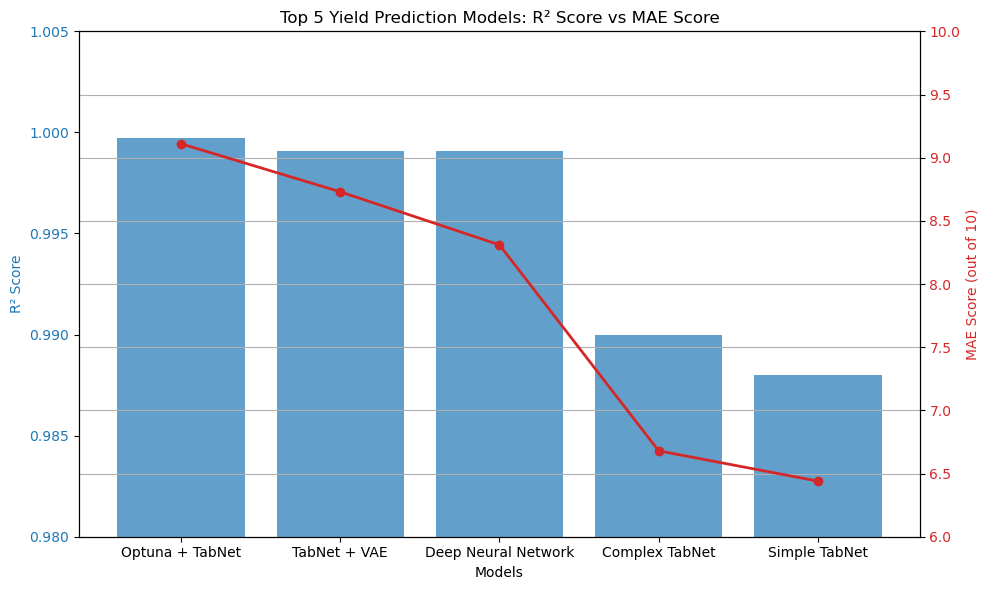

In [1]:
import matplotlib.pyplot as plt

# Top 5 models
models = [
    "Optuna + TabNet",
    "TabNet + VAE",
    "Deep Neural Network",
    "Complex TabNet",
    "Simple TabNet"
]

r2_scores = [0.9997, 0.9991, 0.9991, 0.9900, 0.9880]
mae_scores_10pt = [9.11, 8.73, 8.31, 6.68, 6.44]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# R² Score - Bar Plot
color = 'tab:blue'
ax1.bar(models, r2_scores, color=color, alpha=0.7, label="R² Score")
ax1.set_xlabel("Models")
ax1.set_ylabel("R² Score", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.98, 1.005)

# MAE Score (out of 10) - Line Plot
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(models, mae_scores_10pt, color=color, marker='o', linewidth=2, label="MAE Score (out of 10)")
ax2.set_ylabel("MAE Score (out of 10)", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(6, 10)

# Final touches
plt.title("Top 5 Yield Prediction Models: R² Score vs MAE Score")
plt.xticks(rotation=15)
plt.grid(True)
fig.tight_layout()
plt.show()
